In [1]:
################################################
#### Jingying Wang <astro.jywang@gmail.com> ####
###############################################
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LogNorm
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam_UHF as kb_u

from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'#')

start @ Tue Feb 18 13:06:34 2025#


In [3]:
print (katcali.__version__)

3.0.0


In [4]:
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])

10.0 0.8 1.5
14.0 1.5 1.5


In [5]:
input_file='../level1/'

# Select an observation block and load basic information in


In [6]:
fname='1675632179'#'1684087370'#

data=kio.load_data(fname)
#print data

In [7]:
#print (data)

In [8]:
target,c0,bad_ants,flux_model=kio.check_ants(fname)


calibrator: PictorA, ra,dec= 79d57m25.8149s, -45d46m43.7801s
bad_ants: []


In [9]:
if target=='PKS1934-638':
    tag='1934-638'
if target=='PictorA':
    tag='PictorA'
if target=='3C273':
    tag='3C273'

In [10]:
data.select()
data.select(targets=tag+'_u0.8')
target_start=data.target_indices[0]
data.select()

In [11]:
ants_good=[]
for i in np.array(kio.ant_list(data)):
    if i not in bad_ants:
        ants_good.append(i)
    else:
        print (str(i) + ' is bad')
        
print (fname)
print (ants_good)

1675632179
['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm008', 'm009', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm018', 'm019', 'm021', 'm022', 'm023', 'm024', 'm025', 'm026', 'm027', 'm028', 'm029', 'm030', 'm031', 'm032', 'm033', 'm034', 'm035', 'm037', 'm038', 'm039', 'm040', 'm041', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm052', 'm053', 'm054', 'm055', 'm056', 'm057', 'm058', 'm059', 'm060', 'm061', 'm062', 'm063']


In [12]:
nd_on_time,nd_cycle,nd_set=kd.cal_nd_basic_para(fname)
print (nd_on_time,nd_cycle,nd_set)

0.584099237647 19.4699745882 1675632179.78


# Select ant and polarization, then load data in 

In [13]:
#select ant, polarization, and one channel to show data calibration
ant='m000'
pol='v'
ch_plot= 3300 #ch3608 is for 1023MHz, but Tnd and Trec models cut at 1015MHz
#UHF ch_plot: (272,2869)+(3133,3547) 

In [14]:
#load data, labels, and parameters
ch_ref=ch_plot
data.select(ants=ant,pol=pol)
recv=ant+pol
corr_id=kio.cal_corr_id(data,recv)
assert(recv==data.corr_products[corr_id][0])
assert(recv==data.corr_products[corr_id][1])
print (corr_id,recv)

0 m000v


In [15]:
vis,flags= kio.call_vis(fname,recv)
vis_backup=vis.copy()

['m000v' 'm000v']


In [16]:

ra,dec,az,el=kio.load_coordinates(data)
timestamps,freqs=kio.load_tf(data)
dump_period=data.dump_period
ang_deg=kio.load_ang_deg(ra,dec,c0)
dp_tt,dp_ss,dp_f,dp_w, dp_t,dp_s,dp_slew,dp_stop=kl.cal_dp_label(data,flags,ant,pol,ch_ref,ang_deg)

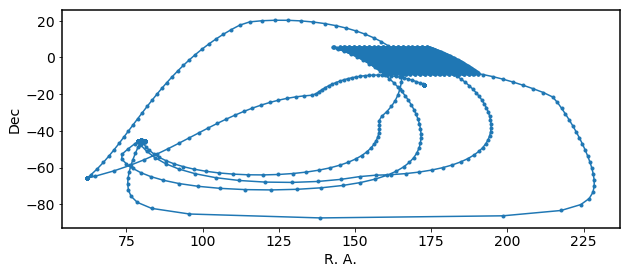

In [17]:
#show the scan route, typically track calibrator + scan sky + track calibrator 
plt.figure(figsize=(10,4))
plt.plot(ra,dec,'.-')
#plt.plot(ra[dp_s],dec[dp_s],'g.')
#plt.plot(ra[dp_tt],dec[dp_tt],'m.')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.show()

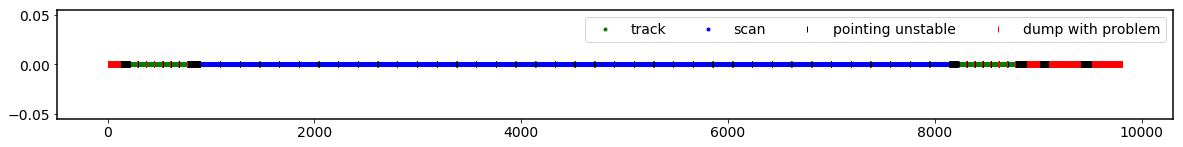

In [18]:
#show time dump label along the scan 
plt.figure(figsize=(20,2))
plt.plot(timestamps[dp_tt]-timestamps[0],np.zeros_like(dp_tt),'g.')
plt.plot(timestamps[dp_ss]-timestamps[0],np.zeros_like(dp_ss),'b.')
plt.plot(timestamps[dp_w]-timestamps[0],np.zeros_like(dp_w),'k|')
plt.plot(timestamps[dp_f]-timestamps[0],np.zeros_like(dp_f),'r|')
plt.legend(['track','scan','pointing unstable','dump with problem'],ncol=4)
plt.show()

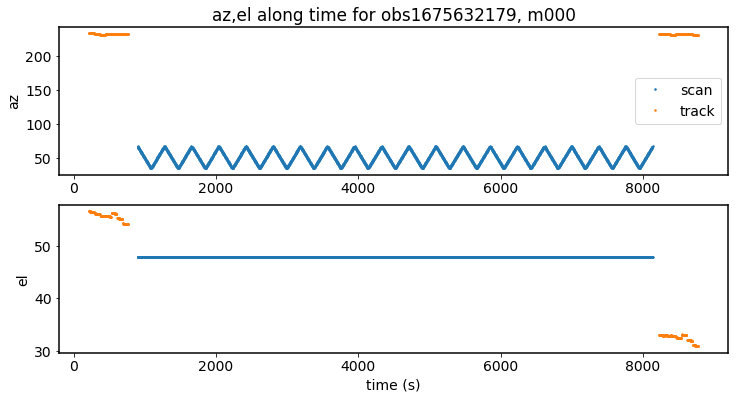

In [19]:
#show the az,el along time
plt.figure(figsize=(12,6))
plt.subplot(211)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],az[dp_ss],'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],az[dp_tt],'.',Markersize=3)
#plt.xlabel('time (s)')
plt.ylabel('az')
plt.title('az,el along time for obs'+str(fname)+', '+str(ant))
plt.legend(['scan','track'])
plt.subplot(212)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],el[dp_ss],'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],el[dp_tt],'.',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('el')
#plt.savefig(str(fname)+'_'+str(ant)+'_azel.pdf',  bbox_inches='tight')
plt.show()

In [20]:
az_corr=az.copy()
az_corr[az>180]-=360

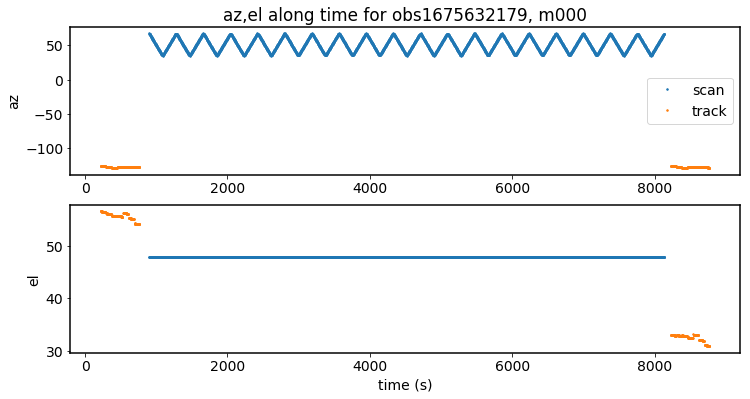

In [21]:
#show the az,el along time
plt.figure(figsize=(12,6))
plt.subplot(211)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],az_corr[dp_ss],'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],az_corr[dp_tt],'.',Markersize=3)
#plt.xlabel('time (s)')
plt.ylabel('az')
plt.title('az,el along time for obs'+str(fname)+', '+str(ant))
plt.legend(['scan','track'])
plt.subplot(212)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],el[dp_ss],'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],el[dp_tt],'.',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('el')
#plt.savefig(str(fname)+'_'+str(ant)+'_azel.pdf',  bbox_inches='tight')
plt.show()

In [22]:
az=az_corr.copy()

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


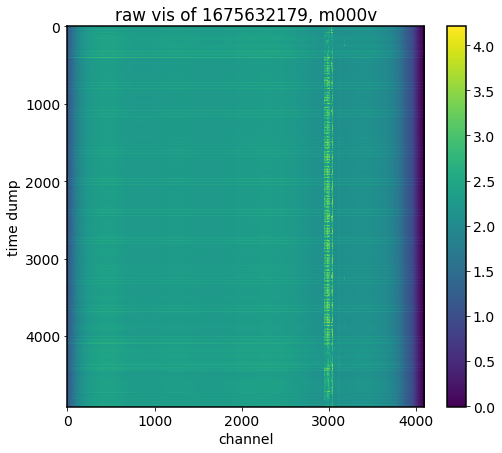

In [23]:
#raw visibility
plt.figure(figsize=(8,7))
plt.imshow(np.log10(vis),aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
#plt.savefig(str(fname)+'_'+str(recv)+'_raw_vis.pdf')
plt.show()

In [24]:
nd_on_edge,nd_off_edge=kd.cal_nd_edges(timestamps,nd_set,nd_cycle,nd_on_time)
print (len(nd_on_edge),len(nd_off_edge))
nd_ratio,nd_0, nd_1x=kd.cal_nd_ratio(timestamps, nd_on_time, nd_on_edge, dump_period)

edge number 0-505
506 506
*** diode 0 was fired out of timestamps list: -26.38239049911499 not in [0,9810.870271921158]
*** diode 1 was fired out of timestamps list: -6.912415981292725 not in [0,9810.870271921158]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


# RFI flagging

In [25]:
#check with .py result
try:
    d3 = pickle.load(open(input_file+fname+'_'+ant+'_mask2', 'rb'))
    print ('mask2 loaded')
except(Exception):
    d3 = pickle.load(open(input_file+fname+'_'+ant+'_mask', 'rb'))
    print ('mask loaded')
    
mask_inter=d3['mask']

vis_clean=np.ma.array(vis,mask=flags)
vis_clean=np.ma.array(vis_clean,mask=mask_inter)


mask loaded


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


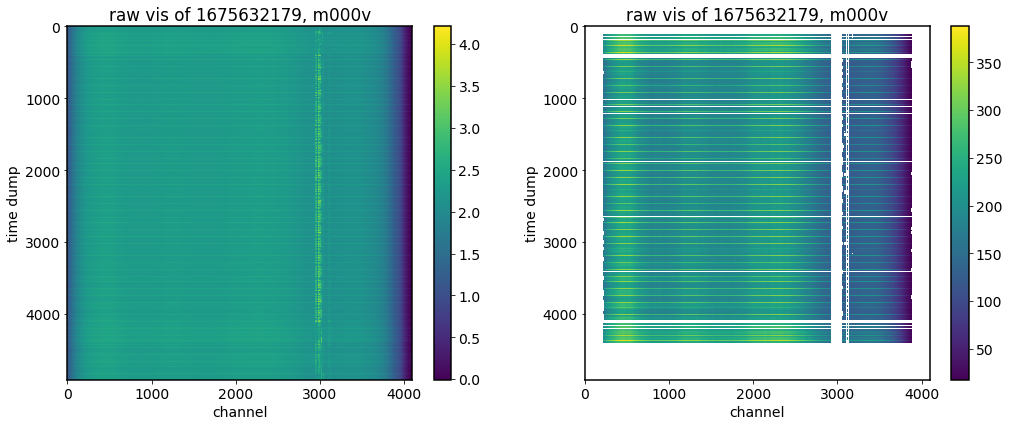

In [26]:
#raw visibility
plt.figure(figsize=(17,6.5))
plt.subplot(121)
plt.imshow(np.log10(vis),aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
plt.subplot(122)
plt.imshow(vis_clean,aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
plt.show()

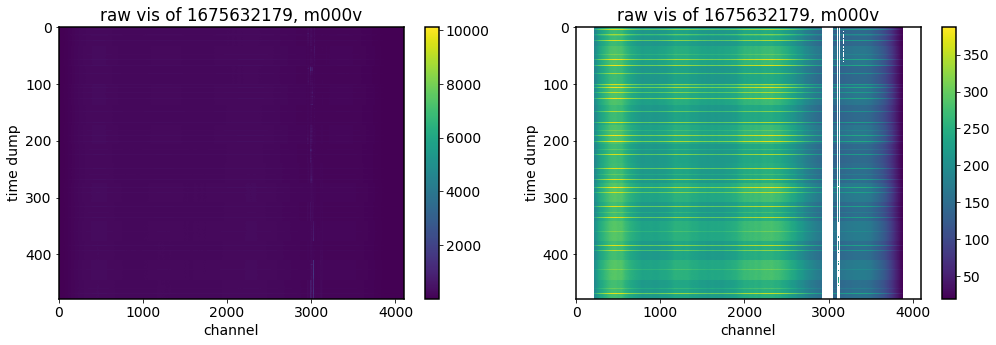

In [27]:
#raw visibility
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.imshow(vis[dp_tt,:],aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
plt.subplot(122)
plt.imshow(vis_clean[dp_tt,:],aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
plt.show()

# calibrate the diode noise using point source calibrator 

## load the foreground models

In [28]:
#load the scan and track labels 
dp_u=kl.cal_dp_u(dp_tt,dp_ss)

#cal_Tspill is for single channel only! cal_Tspill_func has higher efficiency for multi channel calibration


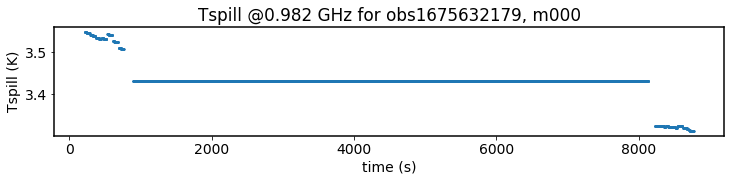

In [29]:
#spill model 
Tspill=km.cal_Tspill(el,pol,freqs, ch_plot,'UHF') #fixed version

plt.figure(figsize=(12,2))
plt.plot(timestamps[dp_u]-timestamps[0],Tspill[dp_u],'.', ms=3)
plt.title('Tspill @'+str(round(freqs[ch_plot]/1e9,3)) +' GHz for obs'+fname+', '+ant)
plt.xlabel('time (s)')
plt.ylabel('Tspill (K)')
plt.show()

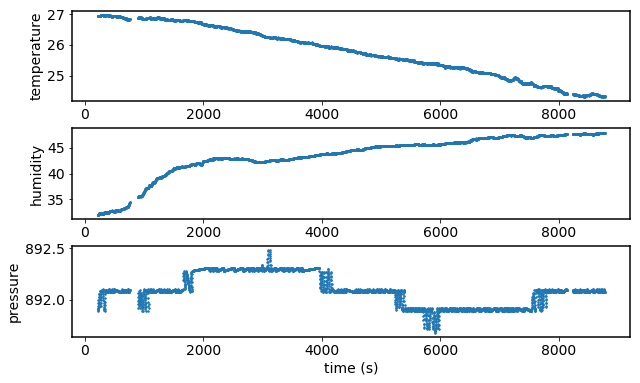

In [30]:
plt.figure(figsize=(10,6))
plt.subplots_adjust(wspace=0.1,hspace=0.3)
plt.subplot(311)
plt.plot(timestamps[dp_u]-timestamps[0],data.temperature[dp_u],'.', ms=3)
plt.ylabel('temperature')
plt.subplot(312)
plt.plot(timestamps[dp_u]-timestamps[0],data.humidity[dp_u],'.', ms=3)
#plt.xlabel('time (s)')
plt.ylabel('humidity')
plt.subplot(313)
plt.plot(timestamps[dp_u]-timestamps[0],data.pressure[dp_u],'.', ms=3)
plt.xlabel('time (s)')
plt.ylabel('pressure')
plt.show()


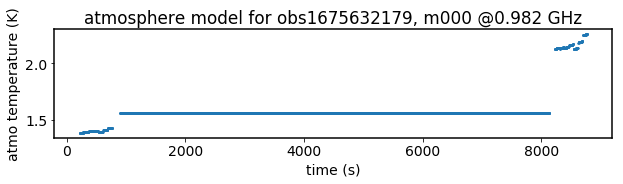

In [31]:
#atmosphere emission model
Tatmo=km.calc_atmosphere_model_1ch(data,ch_plot)

plt.figure(figsize=(10,2))
plt.plot(timestamps[dp_u]-timestamps[0],Tatmo[dp_u],'.', ms=3)
plt.xlabel('time (s)')
plt.ylabel('atmo temperature (K)')
plt.title('atmosphere model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

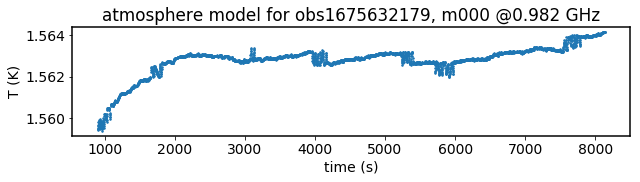

In [32]:
plt.figure(figsize=(10,2))
plt.plot(timestamps[dp_ss]-timestamps[0],Tatmo[dp_ss],'.', ms=3)
plt.xlabel('time (s)')
plt.ylabel('T (K)')
plt.title('atmosphere model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

In [33]:
###test begin

(4914,)


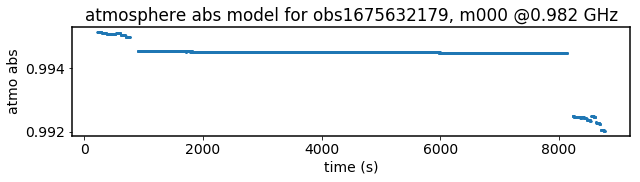

In [34]:
#atmosphere emission model
Tatmo_abs_1ch=km.calc_atmosphere_trans_factor_1ch(data,ch_plot) #old name:calc_atmosphere_abs_factor_1ch

plt.figure(figsize=(10,2))
plt.plot(timestamps[dp_u]-timestamps[0],Tatmo_abs_1ch[dp_u],'.', ms=3)
plt.xlabel('time (s)')
plt.ylabel('atmo abs')
plt.title('atmosphere abs model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

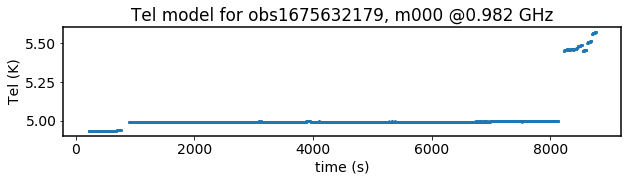

In [35]:
#elevation related emission model
Tel=Tspill+Tatmo 

plt.figure(figsize=(10,2))
plt.plot(data.timestamps[dp_u]-data.timestamps[0],Tel[dp_u],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tel (K)')
plt.title('Tel model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

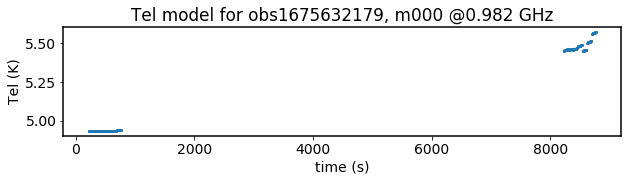

In [36]:
plt.figure(figsize=(10,2))
plt.plot(data.timestamps[dp_tt]-data.timestamps[0],Tel[dp_tt],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tel (K)')
plt.title('Tel model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

#cal_Tnd is for single channel only! Tnd_spl has higher efficiency for multi channel calibration
u.4026 h
u.4026 v
1.1844896435780365


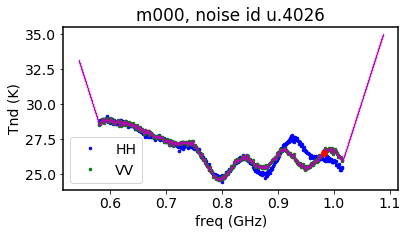

1.1844896435780365 26.497931406503138


In [37]:
#load the diode injection model and get a reference value
#note: diode version are different dish by dish!
Tnd_std,Tnd_ref,noise,Tnd_spl= km.call_Tnd(data, ant, pol,freqs,ch_plot,1)
print (Tnd_std,Tnd_ref)

In [38]:
#end

## load calibrator model: related to the beam model##################


In [39]:
#BM-I: calculated Gaussian
T_ptr0=kb_u.cal_BMI(freqs,ch_plot,flux_model,ang_deg)


*** eta=0.83 is used, not sure also works for UHF
118.8887424896458
alpha=0.7437703018794036


In [40]:
#select beam pattern model
beam_select='HiRes'

In [41]:
#BM-II: pattern fitted Gaussian
T_ptr1=kb_u.cal_BMII(freqs,ch_plot,pol,flux_model,ang_deg,beam_select)


# beam_HiRes_spline_data loaded
alpha=0.7437703018794036


In [42]:
#BM-III:pattern
#dp_ca,dp_cb,dp_c0a, dp_c1a,dp_c2a,dp_c3a,dp_c4a,dp_c0b,dp_c1b,dp_c2b,dp_c3b,dp_c4b=kl.cal_dp_c(fname,data,ant,pol,flags,ch_ref,dp_tt,dp_ss,ang_deg, target_start=target_start,n_src_off=4)
dp_ca,dp_cb,dp_c0a, dp_c1a,dp_c2a,dp_c3a,dp_c4a,dp_c0b,dp_c1b,dp_c2b,dp_c3b,dp_c4b,dp_c1a1,dp_c1a2,dp_c1a3,dp_c1b1,dp_c1b2,dp_c1b3=kl.cal_dp_c(fname,data,ant,pol,flags,ch_ref,dp_tt,dp_ss,ang_deg, target_start=target_start,n_src_off=4)


deg filter start: 0.8000705755248178+/-0.000447732508331413
deg filter end: 0.8000705755248178+/-0.000447732508331413

deg filter start: 0.0003580407918555361+/-0.00028858994216348727
deg filter end: 0.0003580407918555361+/-0.00028858994216348727

deg filter start: 0.7883690393566568+/-0.09551702537265742
deg filter end: 0.7883690393566568+/-0.09551702537265742

deg filter start: 0.777120325075309+/-0.13323685778248084
deg filter end: 0.777120325075309+/-0.13323685778248084

deg filter start: 0.8000108827221261+/-0.0003889824783084607
deg filter end: 0.8000108827221261+/-0.0003889824783084607

# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 35 -> 33
# edge drop applied: 35 -> 33
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 35 -> 33
# edge dr

In [43]:
#test begin

m000v
m005v
m010v
m015v
m020v
*** no data for m020v ***
m025v
m030v
m035v
m040v
m045v
m050v
m055v
m060v
m063v


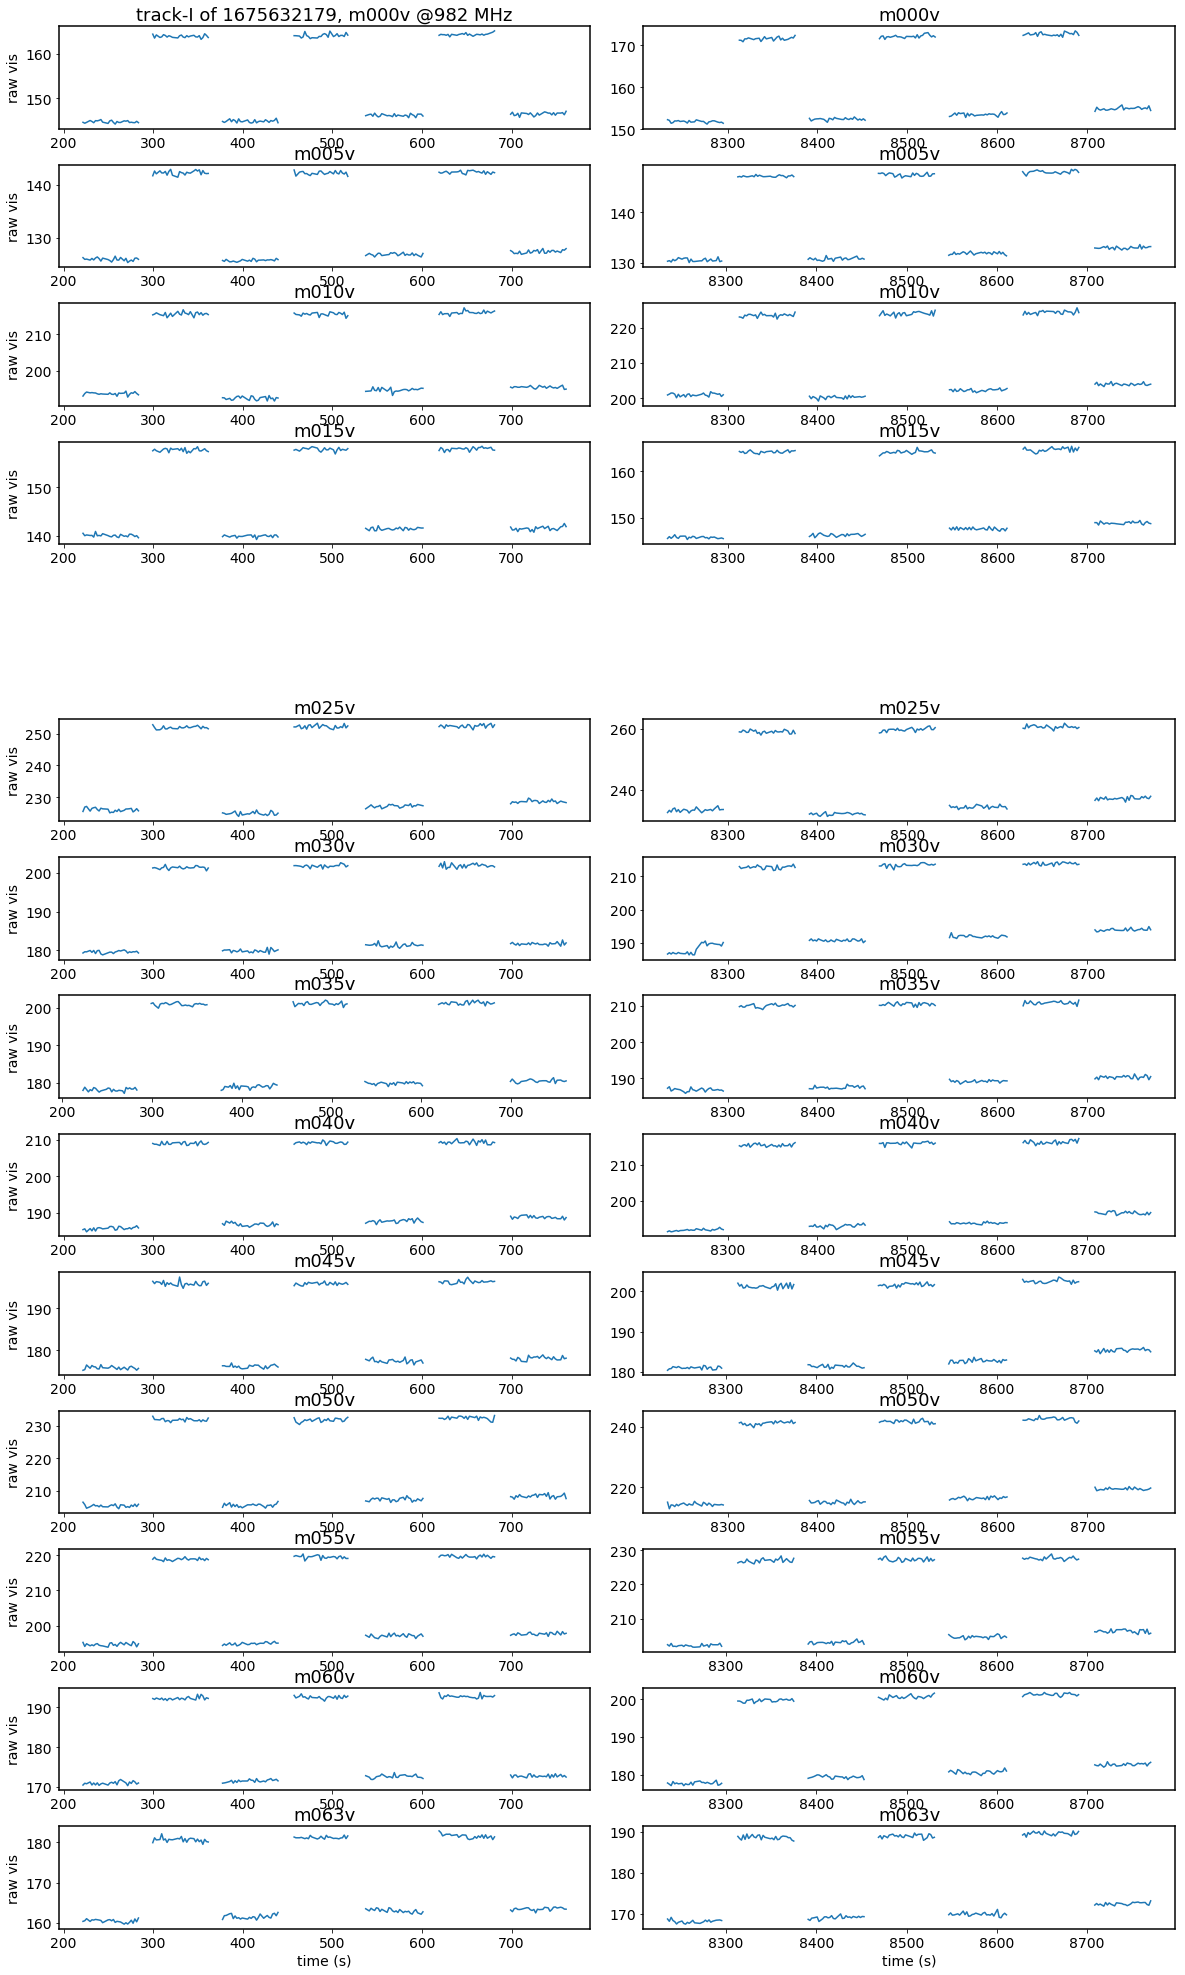

In [44]:
pol111=pol
ant111_list=['m000','m005','m010','m015','m020','m025','m030','m035','m040','m045','m050','m055','m060','m063']
row=len(ant111_list)
plt.figure(figsize=(20,35))
plt.subplots_adjust(wspace=0.1,hspace=0.35)
for ant_i in range(len(ant111_list)):    
    recv111=ant111_list[ant_i]+pol111
    print (recv111,)
    try:
        data111 = pickle.load(open('/idia/projects/hi_im/raw_vis/MeerKLASS2023/'+str(fname)+'/'+str(fname)+'_'+str(recv111)+'_vis_data','rb'),encoding='latin-1')

        vis111=data111['vis']
        flags111=data111['flags']

        visa_ptr111 = np.ma.array(vis111.copy(),mask=flags111)
        visb_ptr111 = visa_ptr111.copy()
        for i in range(len(timestamps)):
            if i not in dp_ca:
                visa_ptr111.mask[i,:]=True
            if i not in dp_cb:
                visb_ptr111.mask[i,:]=True

        plt.subplot(row,2, 2*ant_i+1)
        if (visa_ptr111.mask[nd_0,ch_plot]==True).all()==False:
            plt.plot(timestamps[nd_0]-timestamps[0],visa_ptr111[nd_0,ch_plot])

        plt.ylabel('raw vis')
        if ant_i==len(ant111_list)-1:
            plt.xlabel('time (s)')
        if ant_i==0:
            plt.title('track-I of '+str(fname)+', '+recv111+' @'+ str(round(freqs[ch_plot]/1e6)) +' MHz',fontsize=18)
        if ant_i>0:
            plt.title(recv111,fontsize=18)

        plt.subplot(row,2, 2*ant_i+2)
        if (visb_ptr111.mask[nd_0,ch_plot]==True).all()==False:
            plt.plot(timestamps[nd_0]-timestamps[0],visb_ptr111[nd_0,ch_plot])
        plt.title(recv111,fontsize=18)
    except(Exception):
        print ('*** no data for '+ str(recv111)+' ***')

plt.xlabel('time (s)')
#plt.savefig(str(fname)+'_'+pol111+'.png',  bbox_inches='tight')
plt.show()

m000v
m005v
m010v
m015v
m020v
*** no data for m020v ***
m025v
m030v
m035v
m040v
m045v
m050v
m055v
m060v
m063v


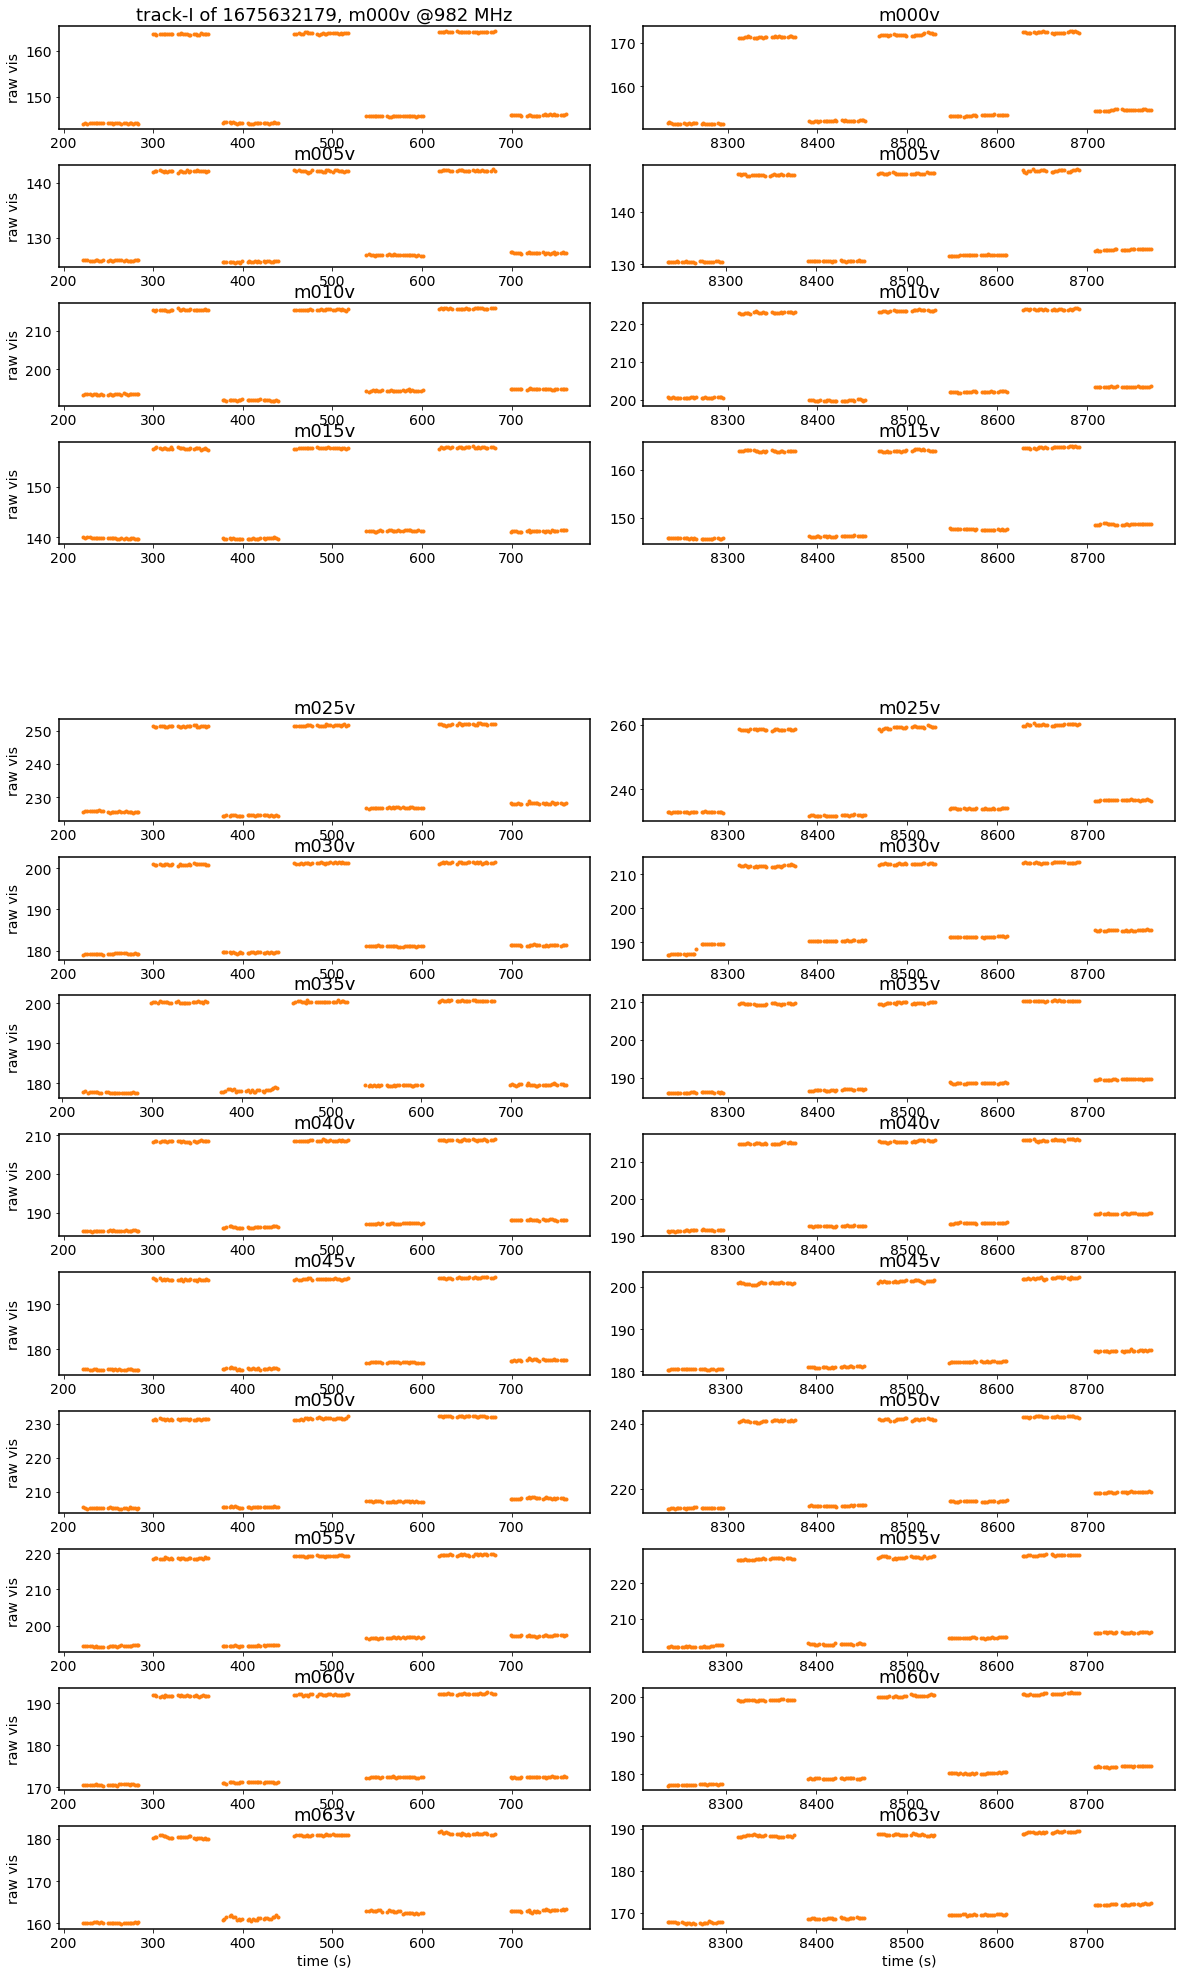

In [45]:
ch_hw=25 #half width of channel bin

row=len(ant111_list)
plt.figure(figsize=(20,35))
plt.subplots_adjust(wspace=0.1,hspace=0.35)
for ant_i in range(len(ant111_list)):    
    recv111=ant111_list[ant_i]+pol111
    print (recv111,)
    try:
        data111 = pickle.load(open('/idia/projects/hi_im/raw_vis/MeerKLASS2023/'+str(fname)+'/'+str(fname)+'_'+str(recv111)+'_vis_data','rb'),encoding='latin-1')

        vis111=data111['vis']
        flags111=data111['flags']

        visa_ptr111 = np.ma.array(vis111.copy(),mask=flags111)
        visb_ptr111 = visa_ptr111.copy()
        for i in range(len(timestamps)):
            if i not in dp_ca:
                visa_ptr111.mask[i,:]=True
            if i not in dp_cb:
                visb_ptr111.mask[i,:]=True

        plt.subplot(row,2, 2*ant_i+1)
        if (visa_ptr111.mask[nd_0,ch_plot]==True).all()==False:
            #plt.plot(timestamps[nd_0]-timestamps[0],visa_ptr111[nd_0,ch_plot])
            plt.plot(timestamps[nd_0]-timestamps[0],np.ma.mean(visa_ptr111[nd_0,ch_plot-ch_hw:ch_plot+ch_hw+1],axis=1),'.',color='C1')
        plt.ylabel('raw vis')
        if ant_i==len(ant111_list)-1:
            plt.xlabel('time (s)')
        if ant_i==0:
            plt.title('track-I of '+str(fname)+', '+recv111+' @'+ str(round(freqs[ch_plot]/1e6)) +' MHz',fontsize=18)
        if ant_i>0:
            plt.title(recv111,fontsize=18)

        plt.subplot(row,2, 2*ant_i+2)
        if (visb_ptr111.mask[nd_0,ch_plot]==True).all()==False:
            #plt.plot(timestamps[nd_0]-timestamps[0],visb_ptr111[nd_0,ch_plot])
            plt.plot(timestamps[nd_0]-timestamps[0],np.ma.mean(visb_ptr111[nd_0,ch_plot-ch_hw:ch_plot+ch_hw+1],axis=1),'.',color='C1')
        plt.title(recv111,fontsize=18)
    except(Exception):
        print ('*** no data for '+ str(recv111)+' ***')

plt.xlabel('time (s)')
#plt.savefig(str(fname)+'_'+pol111+'.png',  bbox_inches='tight')
plt.show()

In [46]:
#test end

In [47]:
Npix=256
Ddeg=6
pattern_fband=kb_u.load_pattern_fband(beam_select,pol)
Aeff_max_fband=kb_u.load_Aeff_max_fband(beam_select,pol)
x_pix,y_pix=kb_u.cal_pix_params(data,c0,Npix,Ddeg)

# VV_pattern_spline_data.npz loaded
(4096, 256, 256)
# beam_HiRes_spline_data loaded
(4914,) (4914,)


127.5 127.5


In [48]:
T_ptr2,pattern,x_pix_max,y_pix_max=kb_u.cal_BMIII_1ch(data,ch_plot,flux_model, dp_ca,dp_cb,pattern_fband,x_pix,y_pix,Aeff_max_fband)

130.41800535768743
### no pattern flip for UHF-band
(array([128]), array([128]))
128 128
alpha=0.7437703018794036


In [49]:
print (np.shape(T_ptr2))

(4914,)


In [50]:
''' not used for UHF
#calculate position
T_ptr2,pattern,pix_label=kb_u.cal_BMIII(fname,data,ch_plot,ant,pol,flux_model,c0,dp_ca,dp_cb,ang_deg,beam_select)
cal_BMIII_1ch(data,ch,flux_model, dp_ca,dp_cb,pattern_fband,x_pix,y_pix,Aeff_max_fband)
x_pix,y_pix,x_pix_max,y_pix_max=pix_label
'''

' not used for UHF\n#calculate position\nT_ptr2,pattern,pix_label=kb_u.cal_BMIII(fname,data,ch_plot,ant,pol,flux_model,c0,dp_ca,dp_cb,ang_deg,beam_select)\ncal_BMIII_1ch(data,ch,flux_model, dp_ca,dp_cb,pattern_fband,x_pix,y_pix,Aeff_max_fband)\nx_pix,y_pix,x_pix_max,y_pix_max=pix_label\n'

In [51]:
pix_ticks=[0,64,128,192,256]


/usr/lib/python3/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


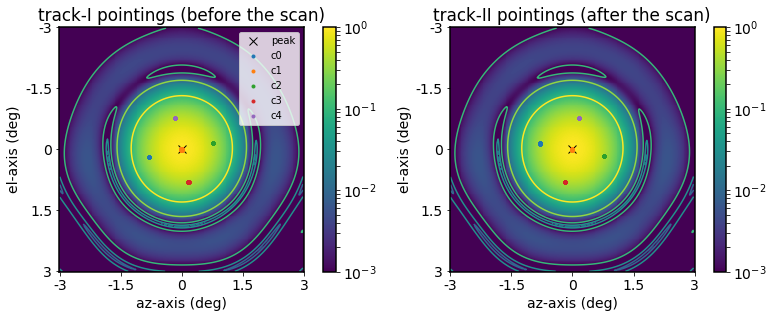

In [52]:
#show pointing position on beam pattern
# imshow pattern is y,x (el,az)
# plot pix_pos is x,y (az,el)
plt.figure(figsize = (14,4.5))
plt.subplots_adjust(wspace=0,hspace=0)
plt.subplot(121)
plt.contour(np.log10(pattern),color='w')
plt.imshow(pattern,norm=LogNorm(vmin=0.001, vmax=1))
plt.plot(x_pix_max,y_pix_max,'kx',ms=8)
plt.plot(x_pix[dp_c0a],y_pix[dp_c0a],'.')
plt.plot(x_pix[dp_c1a],y_pix[dp_c1a],'.')
#if fname in ['1551055211','1551037708','1579725085', '1580260015','1630519596']:
plt.plot(x_pix[dp_c2a],y_pix[dp_c2a],'.')
plt.plot(x_pix[dp_c3a],y_pix[dp_c3a],'.')
plt.plot(x_pix[dp_c4a],y_pix[dp_c4a],'.')
plt.gca().invert_yaxis()
plt.xticks(pix_ticks,['-3','-1.5','0','1.5','3'])
plt.yticks(pix_ticks,['3','1.5','0','-1.5','-3'])
plt.legend(['peak','c0','c1','c2','c3','c4'],fontsize=10)
plt.xlabel('az-axis (deg)')
plt.ylabel('el-axis (deg)')
plt.title('track-I pointings (before the scan)')
plt.colorbar()
plt.subplot(122)
plt.contour(np.log10(pattern),color='w')
plt.imshow(pattern,norm=LogNorm(vmin=0.001, vmax=1))
plt.plot(x_pix_max,y_pix_max,'kx',ms=8)
plt.plot(x_pix[dp_c0b],y_pix[dp_c0b],'.')
plt.plot(x_pix[dp_c1b],y_pix[dp_c1b],'.')
#if fname in ['1551055211','1551037708', '1579725085', '1580260015','1630519596']:
plt.plot(x_pix[dp_c2b],y_pix[dp_c2b],'.')
plt.plot(x_pix[dp_c3b],y_pix[dp_c3b],'.')
plt.plot(x_pix[dp_c4b],y_pix[dp_c4b],'.')
plt.gca().invert_yaxis()
plt.xticks(pix_ticks,['-3','-1.5','0','1.5','3'])
plt.yticks(pix_ticks,['3','1.5','0','-1.5','-3'])
#plt.legend(['peak','c0','c1','c2','c3','c4'],fontsize=10)
plt.xlabel('az-axis (deg)')
plt.ylabel('el-axis (deg)')
plt.title('track-II pointings (after the scan)')
plt.colorbar()
#plt.savefig('F_'+fname+'_pointing_on_beam.pdf', bbox_inches='tight')
plt.show()

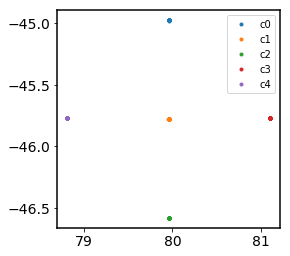

In [53]:
plt.figure(figsize=(4,4))
plt.plot(ra[dp_c0a],dec[dp_c0a],'.')
plt.plot(ra[dp_c1a],dec[dp_c1a],'.')
#if fname in ['1551055211','1551037708','1630519596']:
plt.plot(ra[dp_c2a],dec[dp_c2a],'.')
plt.plot(ra[dp_c3a],dec[dp_c3a],'.')
plt.plot(ra[dp_c4a],dec[dp_c4a],'.')
plt.legend(['c0','c1','c2','c3','c4'],fontsize=10)
plt.show()

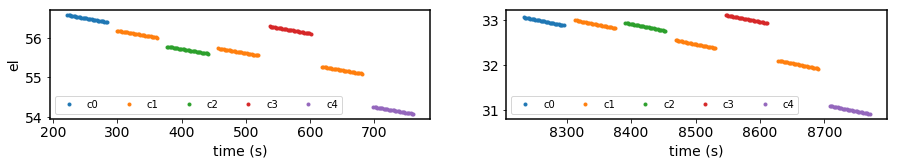

In [54]:
plt.figure(figsize=(15,2))
plt.subplot(121)
plt.plot(timestamps[dp_c0a]-timestamps[0],el[dp_c0a],'.')
plt.plot(timestamps[dp_c1a]-timestamps[0],el[dp_c1a],'.')
#if fname in ['1551055211','1551037708','1630519596']:
plt.plot(timestamps[dp_c2a]-timestamps[0],el[dp_c2a],'.')
plt.plot(timestamps[dp_c3a]-timestamps[0],el[dp_c3a],'.')
plt.plot(timestamps[dp_c4a]-timestamps[0],el[dp_c4a],'.')
plt.legend(['c0','c1','c2','c3','c4'],ncol=5, fontsize=10)
plt.xlabel('time (s)')
plt.ylabel('el')
plt.subplot(122)
plt.plot(timestamps[dp_c0b]-timestamps[0],el[dp_c0b],'.')
plt.plot(timestamps[dp_c1b]-timestamps[0],el[dp_c1b],'.')
#if fname in ['1551055211','1551037708','1630519596']:
plt.plot(timestamps[dp_c2b]-timestamps[0],el[dp_c2b],'.')
plt.plot(timestamps[dp_c3b]-timestamps[0],el[dp_c3b],'.')
plt.plot(timestamps[dp_c4b]-timestamps[0],el[dp_c4b],'.')
plt.legend(['c0','c1','c2','c3','c4'],ncol=5, fontsize=10)
plt.xlabel('time (s)')
plt.show()

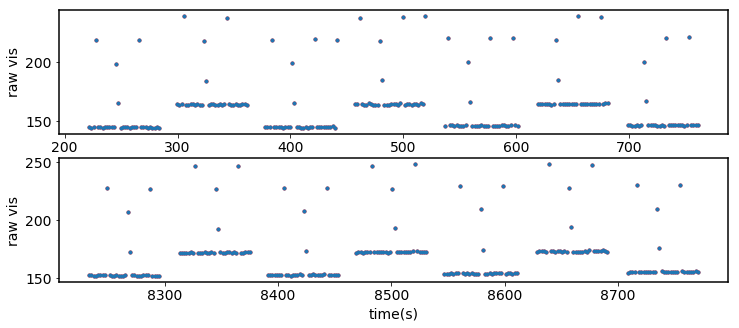

In [55]:
plt.figure(figsize=(12,5))
plt.subplot(211)
plt.plot(timestamps[dp_ca]-timestamps[0],vis[dp_ca,ch_plot],'r.')
plt.plot(timestamps[dp_ca]-timestamps[0],vis_clean[dp_ca,ch_plot],'.')
plt.xlabel('time(s)')
plt.ylabel('raw vis')
plt.subplot(212)
plt.plot(timestamps[dp_cb]-timestamps[0],vis[dp_cb,ch_plot],'r.')
plt.plot(timestamps[dp_cb]-timestamps[0],vis_clean[dp_cb,ch_plot],'.')
plt.xlabel('time(s)')
plt.ylabel('raw vis')
plt.show()


u 4026


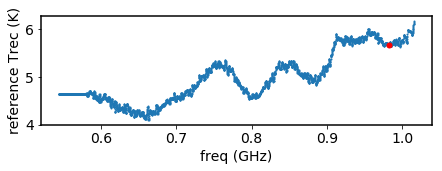

In [56]:
Trec_list=km.cal_Trec(data,ant,pol,freqs,band='UHF') #580-1015 MHz

plt.figure(figsize=(7,2))
plt.plot(freqs[:3550]/1e9,Trec_list[:3550],'.',ms=2)
plt.plot(freqs[ch_plot]/1e9,Trec_list[ch_plot],'ro',ms=5)
plt.xlabel('freq (GHz)')
plt.ylabel('reference Trec (K)')
plt.show()

In [57]:
#Galactic model
nside=64 #healpix nside, 64: Mean Spacing (deg) is 0.9161
#gal_ori=km.cal_Gal_model_np(vis, freqs, ra, dec, ch_plot, ch_plot+1, nside)
gal_ori=km.cal_Gal_model_np2(vis, freqs, ra, dec, 0, len(freqs), nside, model_key=-1)
print ('#Gal model is from Halsam!!!')
gal_ori.flags.writeable=False #avoid change by mistake
gal=gal_ori.copy() #will change for some track data

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
# haslam408_dsds_Remazeilles2014.fits loaded...
# synch_beta.fits loaded...
(3145728,) (49152,)
#Gal model is from Halsam!!!


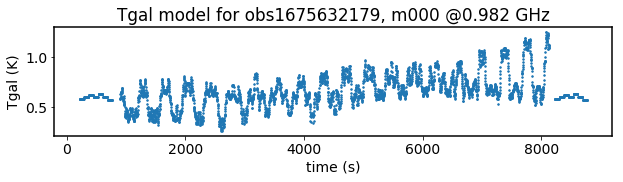

In [58]:
plt.figure(figsize=(10,2))
plt.plot(data.timestamps[dp_u]-data.timestamps[0],gal[dp_u,ch_plot],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tgal (K)')
plt.title('Tgal model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

In [59]:
dp_gal=list(dp_c1a)+list(dp_c1b)

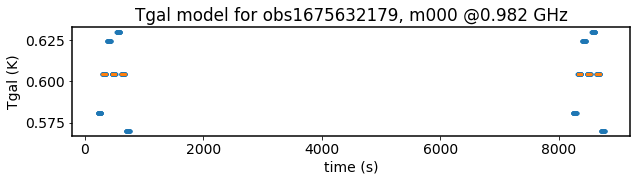

In [60]:
plt.figure(figsize=(10,2))
plt.plot(data.timestamps[dp_tt]-data.timestamps[0],gal[dp_tt,ch_plot],'o',ms=3)
plt.plot(data.timestamps[dp_gal]-data.timestamps[0],gal[dp_gal,ch_plot],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tgal (K)')
plt.title('Tgal model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

In [61]:
gal=gal_ori.copy()
'''
gal_reset=np.mean(gal_ori[dp_gal,ch_plot])
print gal_reset
gal[dp_tt,ch_plot]=np.ones_like(gal_ori[dp_tt,ch_plot])*gal_reset
'''
Tgal=gal[:,ch_plot]


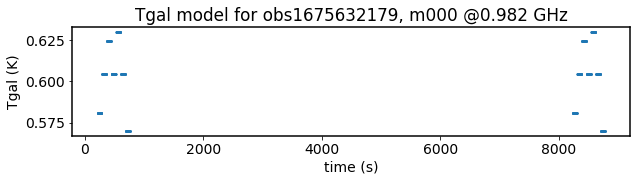

In [62]:
plt.figure(figsize=(10,2))
plt.plot(data.timestamps[dp_tt]-data.timestamps[0],gal[dp_tt,ch_plot],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tgal (K)')
plt.title('Tgal model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

## calibrate diode noise

In [63]:
#####choose beam model
T_ptr=T_ptr2 #BM-III 

### track before scan########################


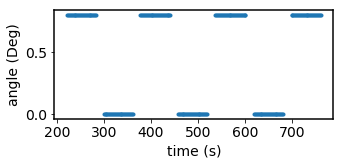

In [64]:
#check angular distance
plt.figure(figsize=(5,2))
plt.plot(timestamps[dp_ca]-timestamps[0],ang_deg[dp_ca],'.')
plt.xlabel('time (s)')
plt.ylabel('angle (Deg)')
plt.show()


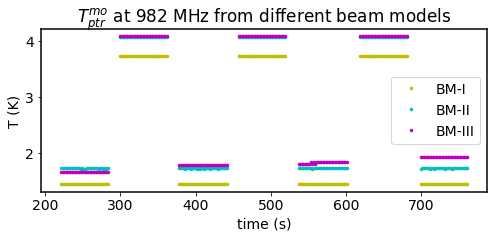

In [65]:
#check Tptr from different model

plt.figure(figsize=(8,3))
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr0[dp_ca],'y.',ms=5)
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr1[dp_ca],'c.',ms=5)
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr2[dp_ca],'m.',ms=5)
plt.xlabel('time (s)')
plt.ylabel('T (K)')
plt.title('$T_{ptr}^{mo}$ at '+str(int(freqs[ch_plot]/1e6))+' MHz from different beam models')
plt.legend(['BM-I', 'BM-II', 'BM-III'])
#plt.savefig('F_'+fname+'_ptr_contri_model.pdf', bbox_inches='tight')
plt.show()

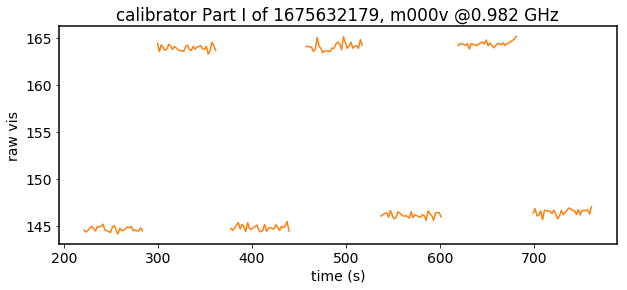

In [66]:
#select raw vis for track befor scan
visa_ptr = vis_clean.copy()
#visa_ptr_raw = np.ma.array(vis_backup.copy(),mask=flags)
for i in range(len(timestamps)):
    if i not in dp_ca:
        visa_ptr.mask[i,:]=True
        #visa_ptr_raw.mask[i,:]=True
#show diode off data
plt.figure(figsize=(10,4))

plt.plot(timestamps[nd_0]-timestamps[0],visa_ptr[nd_0,ch_plot],c='C1')
#plt.plot(timestamps[nd_0]-timestamps[0],visa_ptr_raw[nd_0,ch_plot],c='grey',zorder=0)
plt.xlabel('time (s)')
plt.ylabel('raw vis')
#plt.legend(['raw data to be fitted','raw data'],ncol=2, fontsize=12)
plt.title('calibrator Part I of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
plt.show()

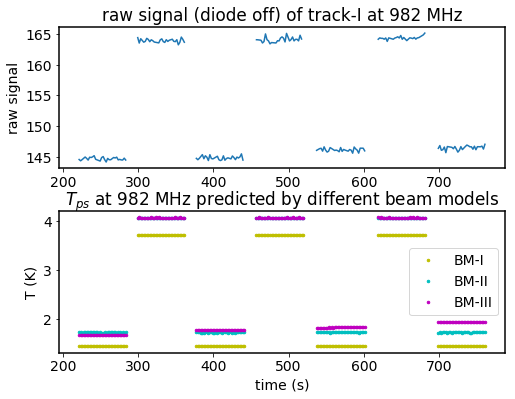

In [67]:
#check Tptr from different model

plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace =0, hspace =0.3)
plt.subplot(211)
plt.plot(timestamps[nd_0]-timestamps[0],visa_ptr[nd_0,ch_plot])
#plt.xlabel('time (s)')
plt.ylabel('raw signal')
plt.title('raw signal (diode off) of track-I at '+ str(int(freqs[ch_plot]/1e6)) +' MHz')
plt.subplot(212)
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr0[dp_ca],'y.',ms=5)
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr1[dp_ca],'c.',ms=5)
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr2[dp_ca],'m.',ms=5)
plt.xlabel('time (s)')
plt.ylabel('T (K)')
plt.title('$T_{ps}$ at '+str(int(freqs[ch_plot]/1e6))+' MHz predicted by different beam models')
plt.legend(['BM-I', 'BM-II', 'BM-III'])
#plt.savefig('F_'+fname+'_ptr_contri_model1.pdf', bbox_inches='tight')
plt.show()

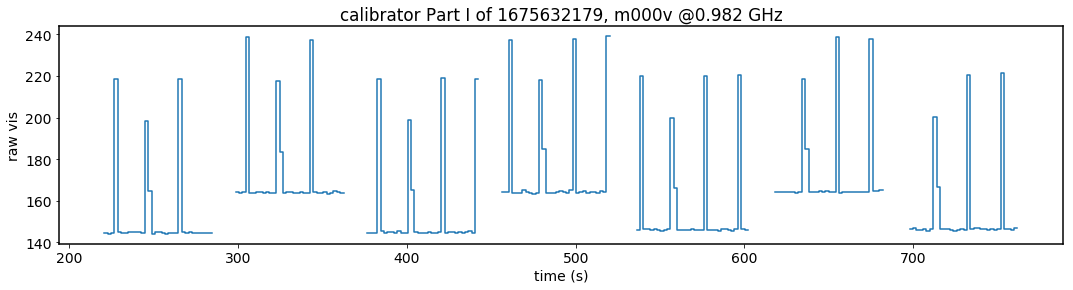

In [68]:
#diode on and diode off 
plt.figure(figsize=(18,4))
plt.step(timestamps-timestamps[0],visa_ptr[:,ch_plot],where='mid')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.title('calibrator Part I of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
plt.show()

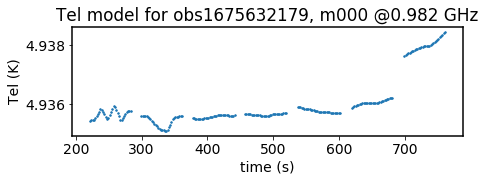

In [69]:
#show Tel for track before scan
plt.figure(figsize=(7,2))
plt.plot(data.timestamps[dp_ca]-data.timestamps[0],Tel[dp_ca],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tel (K)')
plt.title('Tel model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

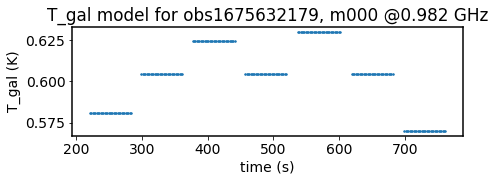

In [70]:
#show Tgal for track efor scan
#Tgal=gal[:,ch_plot]
plt.figure(figsize=(7,2))
plt.plot(data.timestamps[dp_ca]-data.timestamps[0],Tgal[dp_ca],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('T_gal (K)')
plt.title('T_gal model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()
plt.show()

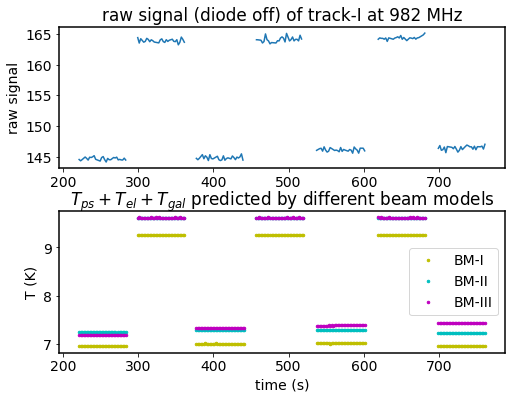

In [71]:
#check Tptr from different model

plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace =0, hspace =0.3)
plt.subplot(211)
plt.plot(timestamps[nd_0]-timestamps[0],visa_ptr[nd_0,ch_plot])
#plt.xlabel('time (s)')
plt.ylabel('raw signal')
plt.title('raw signal (diode off) of track-I at '+ str(int(freqs[ch_plot]/1e6)) +' MHz')
plt.subplot(212)
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr0[dp_ca]+Tel[dp_ca]+Tgal[dp_ca],'y.',ms=5)
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr1[dp_ca]+Tel[dp_ca]+Tgal[dp_ca],'c.',ms=5)
plt.plot(timestamps[dp_ca]-timestamps[0],T_ptr2[dp_ca]+Tel[dp_ca]+Tgal[dp_ca],'m.',ms=5)
plt.xlabel('time (s)')
plt.ylabel('T (K)')
plt.title('$T_{ps}+T_{el}+T_{gal}$ predicted by different beam models')
plt.legend(['BM-I', 'BM-II', 'BM-III'])
#plt.savefig('F_'+fname+'_ptr_contri_model1.pdf', bbox_inches='tight')
plt.show()

In [72]:
####set input parameters
ga0,gb0=ks.cal_gain0(fname,data,ant,pol,flags,ch_plot,dp_tt,dp_ss,ang_deg,T_ptr,vis_clean,n_src_off=4,target_start=target_start) #gain level ##need to check the label still works for 2021 data!!!!!!
print (ga0,gb0)
assert(isinstance(ga0,np.float))
assert(isinstance(gb0,np.float))

deg filter start: 0.8000705755248178+/-0.000447732508331413
deg filter end: 0.8000705755248178+/-0.000447732508331413

deg filter start: 0.0003580407918555361+/-0.00028858994216348727
deg filter end: 0.0003580407918555361+/-0.00028858994216348727

deg filter start: 0.7883690393566568+/-0.09551702537265742
deg filter end: 0.7883690393566568+/-0.09551702537265742

deg filter start: 0.777120325075309+/-0.13323685778248084
deg filter end: 0.777120325075309+/-0.13323685778248084

deg filter start: 0.8000108827221261+/-0.0003889824783084607
deg filter end: 0.8000108827221261+/-0.0003889824783084607

# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 35 -> 33
# edge drop applied: 35 -> 33
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 34 -> 32
# edge drop applied: 35 -> 33
# edge dr

In [73]:
Trec0=Trec_list[ch_plot]
print (Trec0)
eta_p0=1.0
func_sm_param0=[Trec0]
func_gt_param0=[ga0,0,0,0,0]
print (Tnd_ref)
####fitting
instru_pa=ks.solve_params0_v3(timestamps, visa_ptr, ch_plot, nd_ratio, T_ptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal, func_gt_param0, func_sm_param0, nd_0, nd_1x, band='UHF')


####get fitting result
Tnda=instru_pa[0]
eta_pa=instru_pa[1]
sma=instru_pa[2]
gta=instru_pa[3:]

print (Tnda, eta_pa, sma, gta)


5.668362274169923
26.497931406503138
Optimization terminated successfully.
         Current function value: 557.057234
         Iterations: 28
         Function evaluations: 4373
30.380942091563522 1.0 7.355935852188258 [ 8.67701537 -0.91595875 -0.95057873  1.744177    1.58213924]


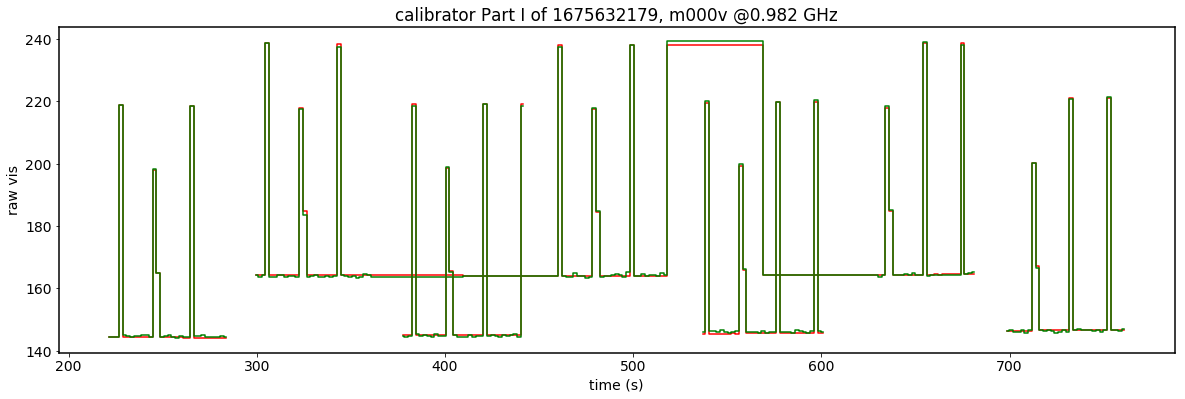

In [74]:
##show model and raw vis
plt.figure(figsize=(20,6))
m=ks.calc_total_model_v3(timestamps, nd_ratio, T_ptr, eta_pa, Tnda, Tel, Tgal, gta, sma, nd_0, nd_1x)
m=np.ma.array(m,mask=visa_ptr[:,ch_plot].mask)
plt.step(timestamps[dp_c0a]-timestamps[0],m[dp_c0a],'r-',where='mid')
plt.step(timestamps[dp_c1a]-timestamps[0],m[dp_c1a],'r-',where='mid')

plt.step(timestamps[dp_c0a]-timestamps[0],visa_ptr[dp_c0a,ch_plot],'g-',where='mid')
plt.step(timestamps[dp_c1a]-timestamps[0],visa_ptr[dp_c1a,ch_plot],'g-',where='mid')
#if fname in ['1551055211','1551037708','1630519596']:
plt.step(timestamps[dp_c2a]-timestamps[0],m[dp_c2a],'r-',where='mid')
plt.step(timestamps[dp_c3a]-timestamps[0],m[dp_c3a],'r-',where='mid')
plt.step(timestamps[dp_c4a]-timestamps[0],m[dp_c4a],'r-',where='mid')
plt.step(timestamps[dp_c2a]-timestamps[0],visa_ptr[dp_c2a,ch_plot],'g-',where='mid')
plt.step(timestamps[dp_c3a]-timestamps[0],visa_ptr[dp_c3a,ch_plot],'g-',where='mid')
plt.step(timestamps[dp_c4a]-timestamps[0],visa_ptr[dp_c4a,ch_plot],'g-',where='mid')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.title('calibrator Part I of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
plt.show()

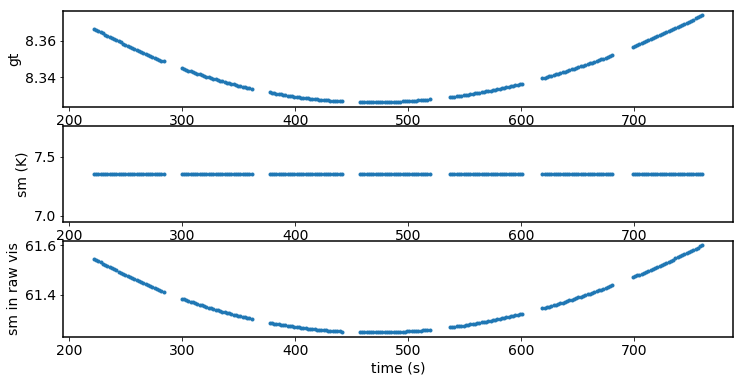

In [75]:
#show curves for fitting parameters
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.plot(timestamps[dp_ca]-timestamps[0],ks.func_gt(timestamps,gta)[dp_ca],'.')
plt.ylabel('gt')
plt.subplot(312)
plt.plot(timestamps[dp_ca]-timestamps[0],ks.func_sm(timestamps,sma)[dp_ca],'.')
plt.ylabel('sm (K)')
plt.subplot(313)
plt.plot(timestamps[dp_ca]-timestamps[0],ks.func_gt(timestamps,gta)[dp_ca]*ks.func_sm(timestamps,sma)[dp_ca],'.')
plt.xlabel('time (s)')
plt.ylabel('sm in raw vis')
plt.show()

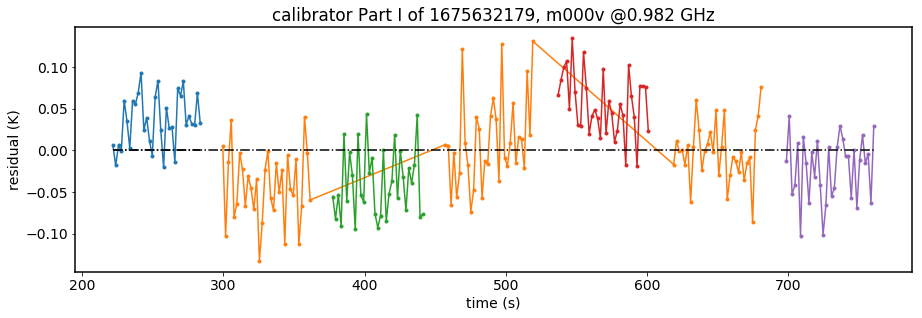

In [76]:
#show residuals
plt.figure(figsize=(15,4.5))
g=ks.func_gt(timestamps,gta)
m=ks.calc_total_model_v3(timestamps, nd_ratio, T_ptr, eta_pa, Tnda, Tel, Tgal, gta, sma, nd_0, nd_1x)
plt.plot([timestamps[dp_c0a][0]-timestamps[0],timestamps[dp_c0a][-1]-timestamps[0]],[0,0],'k-.')
plt.plot(timestamps[dp_c0a]-timestamps[0],(visa_ptr[dp_c0a,ch_plot]-m[dp_c0a])/g[dp_c0a],'.-')
plt.plot(timestamps[dp_c1a]-timestamps[0],(visa_ptr[dp_c1a,ch_plot]-m[dp_c1a])/g[dp_c1a],'.-')
#if fname in ['1551055211','1551037708','1579725085', '1580260015','1630519596']:
plt.plot(timestamps[dp_c2a]-timestamps[0],(visa_ptr[dp_c2a,ch_plot]-m[dp_c2a])/g[dp_c2a],'.-')
plt.plot(timestamps[dp_c3a]-timestamps[0],(visa_ptr[dp_c3a,ch_plot]-m[dp_c3a])/g[dp_c3a],'.-')
plt.plot(timestamps[dp_c4a]-timestamps[0],(visa_ptr[dp_c4a,ch_plot]-m[dp_c4a])/g[dp_c4a],'.-')
plt.plot([timestamps[dp_c0a][0]-timestamps[0],timestamps[dp_c4a][-1]-timestamps[0]],[0,0],'k-.')
plt.xlabel('time (s)')
plt.ylabel('residual (K)')
plt.title('calibrator Part I of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
#plt.savefig('caliA_ch'+str(ch_plot)+'.pdf')
plt.show()


### track after scan########################


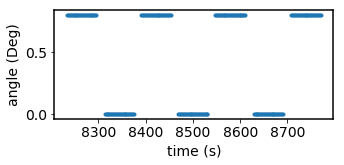

In [77]:
#check angular distance
plt.figure(figsize=(5,2))
plt.plot(timestamps[dp_cb]-timestamps[0],ang_deg[dp_cb],'.')
plt.xlabel('time (s)')
plt.ylabel('angle (Deg)')
plt.show()


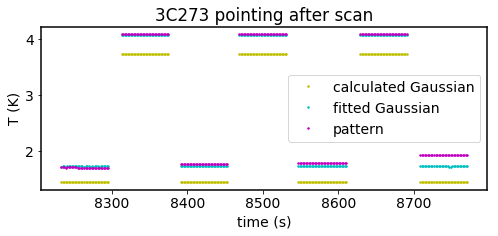

In [78]:
#check Tptr from different model

plt.figure(figsize=(8,3))
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr0[dp_cb],'y.',ms=3)
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr1[dp_cb],'c.',ms=3)
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr2[dp_cb],'m.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('T (K)')
plt.title('3C273 pointing after scan')
plt.legend(['calculated Gaussian', 'fitted Gaussian', 'pattern'])
plt.show()

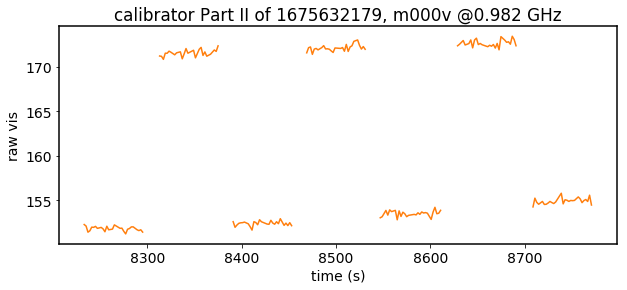

In [79]:
#select raw vis for track befor scan
visb_ptr = vis_clean.copy()
#visb_ptr_raw = np.ma.array(vis_backup.copy(),mask=flags)
for i in range(len(timestamps)):
    if i not in dp_cb:
        visb_ptr.mask[i,:]=True
        #visb_ptr_raw.mask[i,:]=True
#show diode off data
plt.figure(figsize=(10,4))

plt.plot(timestamps[nd_0]-timestamps[0],visb_ptr[nd_0,ch_plot],c='C1')
#plt.plot(timestamps[nd_0]-timestamps[0],visb_ptr_raw[nd_0,ch_plot],c='grey',zorder=0)
plt.xlabel('time (s)')
plt.ylabel('raw vis')
#plt.legend(['raw data to be fitted','raw data'],ncol=2, fontsize=12)
plt.title('calibrator Part II of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
plt.show()

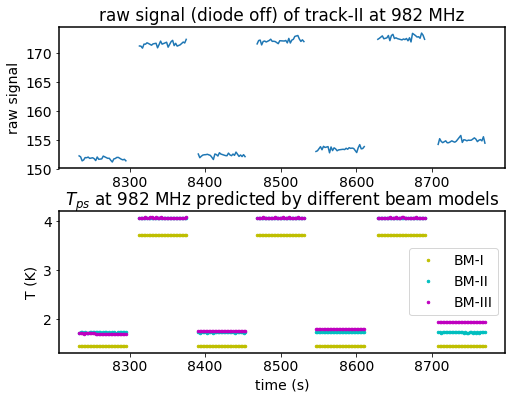

In [80]:
#check Tptr from different model

plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace =0, hspace =0.3)
plt.subplot(211)
plt.plot(timestamps[nd_0]-timestamps[0],visb_ptr[nd_0,ch_plot])
#plt.xlabel('time (s)')
plt.ylabel('raw signal')
plt.title('raw signal (diode off) of track-II at '+ str(int(freqs[ch_plot]/1e6)) +' MHz')
plt.subplot(212)
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr0[dp_cb],'y.',ms=5)
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr1[dp_cb],'c.',ms=5)
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr2[dp_cb],'m.',ms=5)
plt.xlabel('time (s)')
plt.ylabel('T (K)')
plt.title('$T_{ps}$ at '+str(int(freqs[ch_plot]/1e6))+' MHz predicted by different beam models')
plt.legend(['BM-I', 'BM-II', 'BM-III'])
#plt.savefig('F_'+fname+'_ptr_contri_model2.pdf', bbox_inches='tight')
plt.show()

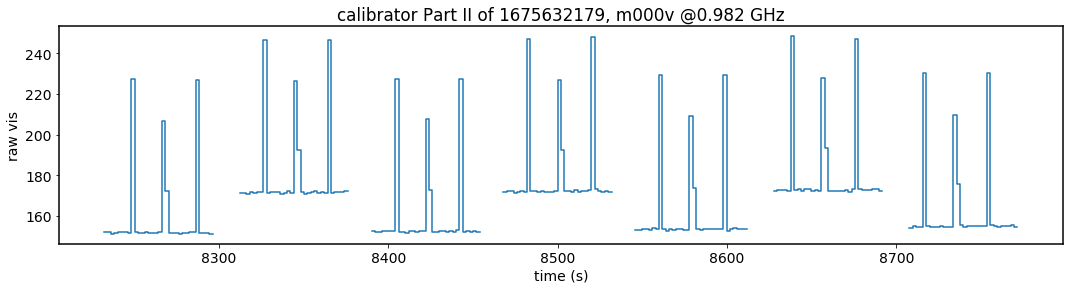

In [81]:
#diode on and diode off 
plt.figure(figsize=(18,4))
plt.step(timestamps-timestamps[0],visb_ptr[:,ch_plot],where='mid')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.title('calibrator Part II of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
plt.show()

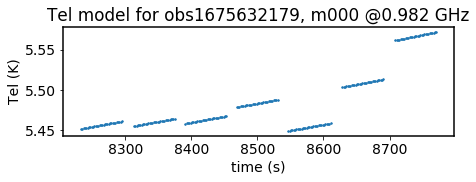

In [82]:
#show Tel for track after scan
plt.figure(figsize=(7,2))
plt.plot(data.timestamps[dp_cb]-data.timestamps[0],Tel[dp_cb],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tel (K)')
plt.title('Tel model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

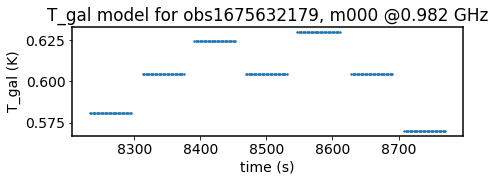

In [83]:
#show Tgal for track after scan
plt.figure(figsize=(7,2))
plt.plot(data.timestamps[dp_cb]-data.timestamps[0],Tgal[dp_cb],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('T_gal (K)')
plt.title('T_gal model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()
plt.show()

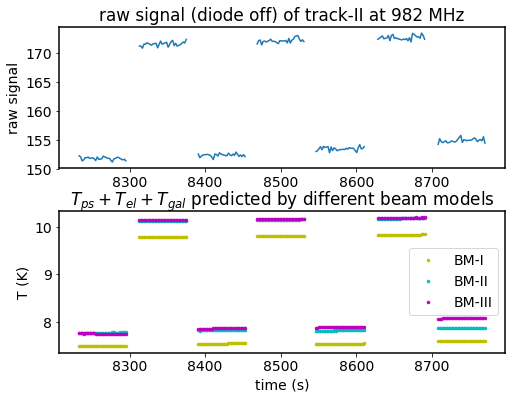

In [84]:
#check Tptr from different model

plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace =0, hspace =0.3)
plt.subplot(211)
plt.plot(timestamps[nd_0]-timestamps[0],visb_ptr[nd_0,ch_plot])
#plt.xlabel('time (s)')
plt.ylabel('raw signal')
plt.title('raw signal (diode off) of track-II at '+ str(int(freqs[ch_plot]/1e6)) +' MHz')
plt.subplot(212)
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr0[dp_cb]+Tel[dp_cb]+Tgal[dp_cb],'y.',ms=5)
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr1[dp_cb]+Tel[dp_cb]+Tgal[dp_cb],'c.',ms=5)
plt.plot(timestamps[dp_cb]-timestamps[0],T_ptr2[dp_cb]+Tel[dp_cb]+Tgal[dp_cb],'m.',ms=5)
plt.xlabel('time (s)')
plt.ylabel('T (K)')
plt.title('$T_{ps}+T_{el}+T_{gal}$ predicted by different beam models')
plt.legend(['BM-I', 'BM-II', 'BM-III'])
#plt.savefig('F_'+fname+'_ptr_contri_model2.pdf', bbox_inches='tight')
plt.show()

In [85]:
####set input parameters
#Trec0=Trec_list[ch_plot]
print (Trec0)
eta_p0=1.0
func_sm_param0=[Trec0]
func_gt_param0=[gb0,0,0,0,0]

print (Tnd_ref)

####fitting######
instru_pb=ks.solve_params0_v3(timestamps, visb_ptr, ch_plot, nd_ratio, T_ptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal,
                      func_gt_param0, func_sm_param0, nd_0, nd_1x, band='UHF')

######get fitting result#####
Tndb=instru_pb[0]
eta_pb=instru_pb[1]
smb=instru_pb[2]
gtb=instru_pb[3:]

print (Tndb, eta_pb, smb, gtb)

5.668362274169923
26.497931406503138
Optimization terminated successfully.
         Current function value: 532.164552
         Iterations: 36
         Function evaluations: 6179
30.548405701536712 1.0 7.504880559386497 [ 63.99539666 -47.93315579 -85.02768661 121.97884048 -52.04179008]


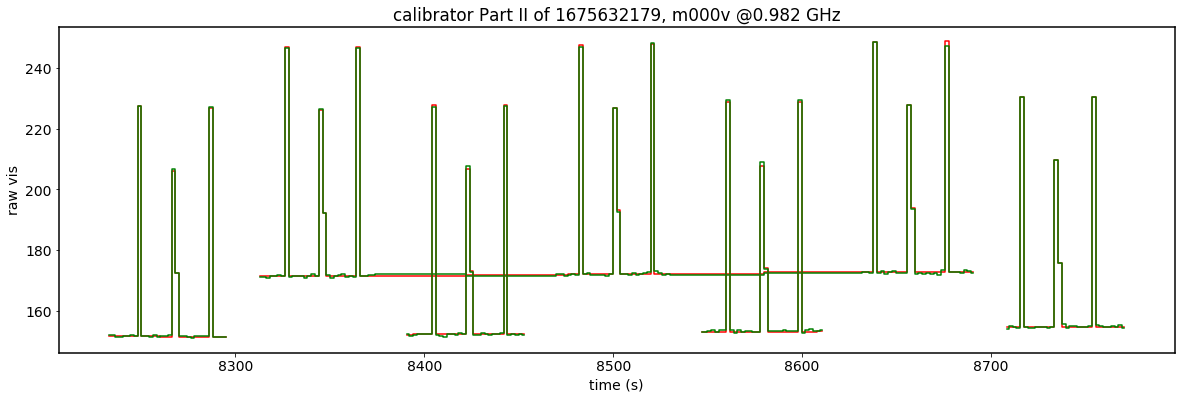

In [86]:
##show model and raw vis
plt.figure(figsize=(20,6))
m=ks.calc_total_model_v3(timestamps, nd_ratio, T_ptr, eta_pb, Tndb, Tel, Tgal, gtb, smb, nd_0, nd_1x)
m=np.ma.array(m,mask=visb_ptr[:,ch_plot].mask)
plt.step(timestamps[dp_c0b]-timestamps[0],m[dp_c0b],'r-',where='mid')
plt.step(timestamps[dp_c1b]-timestamps[0],m[dp_c1b],'r-',where='mid')
plt.step(timestamps[dp_c0b]-timestamps[0],visb_ptr[dp_c0b,ch_plot],'g-',where='mid')
plt.step(timestamps[dp_c1b]-timestamps[0],visb_ptr[dp_c1b,ch_plot],'g-',where='mid')
#if fname in ['1551055211','1551037708','1579725085', '1580260015','1630519596']:
plt.step(timestamps[dp_c2b]-timestamps[0],m[dp_c2b],'r-',where='mid')
plt.step(timestamps[dp_c3b]-timestamps[0],m[dp_c3b],'r-',where='mid')
plt.step(timestamps[dp_c4b]-timestamps[0],m[dp_c4b],'r-',where='mid')
plt.step(timestamps[dp_c2b]-timestamps[0],visb_ptr[dp_c2b,ch_plot],'g-',where='mid')
plt.step(timestamps[dp_c3b]-timestamps[0],visb_ptr[dp_c3b,ch_plot],'g-',where='mid')
plt.step(timestamps[dp_c4b]-timestamps[0],visb_ptr[dp_c4b,ch_plot],'g-',where='mid')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.title('calibrator Part II of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
plt.show()

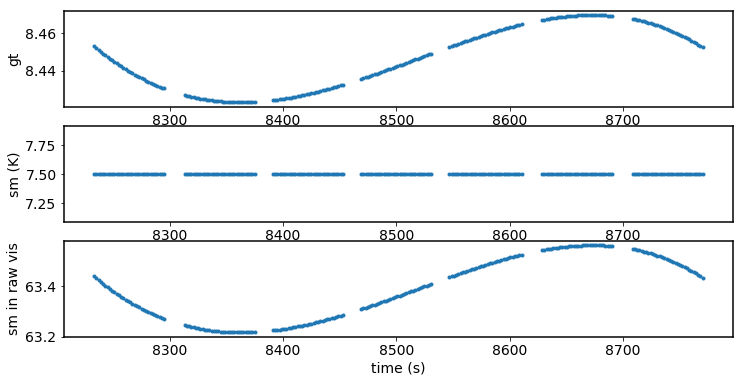

In [87]:
#show curves for fitting parametrs
plt.figure(figsize=(12,6))
plt.subplot(311)
plt.plot(timestamps[dp_cb]-timestamps[0],ks.func_gt(timestamps,gtb)[dp_cb],'.')
plt.ylabel('gt')
plt.subplot(312)
plt.plot(timestamps[dp_cb]-timestamps[0],ks.func_sm(timestamps,smb)[dp_cb],'.')
plt.ylabel('sm (K)')
plt.subplot(313)
plt.plot(timestamps[dp_cb]-timestamps[0],ks.func_gt(timestamps,gtb)[dp_cb]*ks.func_sm(timestamps,smb)[dp_cb],'.')
plt.xlabel('time (s)')
plt.ylabel('sm in raw vis')
plt.show()

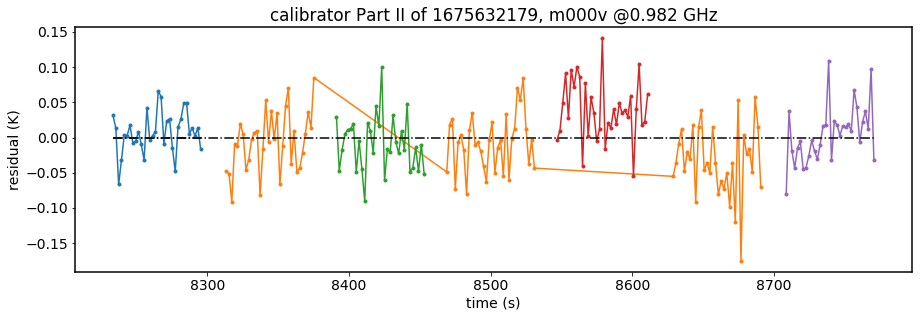

In [88]:
#show residuals
plt.figure(figsize=(15,4.5))
g=ks.func_gt(timestamps,gtb)
m=ks.calc_total_model_v3(timestamps, nd_ratio, T_ptr, eta_pb, Tndb, Tel, Tgal, gtb, smb, nd_0, nd_1x)
plt.plot([timestamps[dp_c0b][0]-timestamps[0],timestamps[dp_c0b][-1]-timestamps[0]],[0,0],'k-.')
plt.plot(timestamps[dp_c0b]-timestamps[0],(visb_ptr[dp_c0b,ch_plot]-m[dp_c0b])/g[dp_c0b],'.-')
plt.plot(timestamps[dp_c1b]-timestamps[0],(visb_ptr[dp_c1b,ch_plot]-m[dp_c1b])/g[dp_c1b],'.-')
#if fname in ['1551055211','1551037708','1579725085', '1580260015','1630519596']:
plt.plot(timestamps[dp_c2b]-timestamps[0],(visb_ptr[dp_c2b,ch_plot]-m[dp_c2b])/g[dp_c2b],'.-')
plt.plot(timestamps[dp_c3b]-timestamps[0],(visb_ptr[dp_c3b,ch_plot]-m[dp_c3b])/g[dp_c3b],'.-')
plt.plot(timestamps[dp_c4b]-timestamps[0],(visb_ptr[dp_c4b,ch_plot]-m[dp_c4b])/g[dp_c4b],'.-')
plt.plot([timestamps[dp_c0b][0]-timestamps[0],timestamps[dp_c4b][-1]-timestamps[0]],[0,0],'k-.')
plt.xlabel('time (s)')
plt.ylabel('residual (K)')
plt.title('calibrator Part II of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
#plt.savefig('caliB_ch'+str(ch_plot)+'.pdf')
plt.show()

#resi_b=(visb_ptr[dp_c3b,ch_plot]-m[dp_c3b])/g[dp_c3b]
#print resi_b.mean(),resi_b.std()

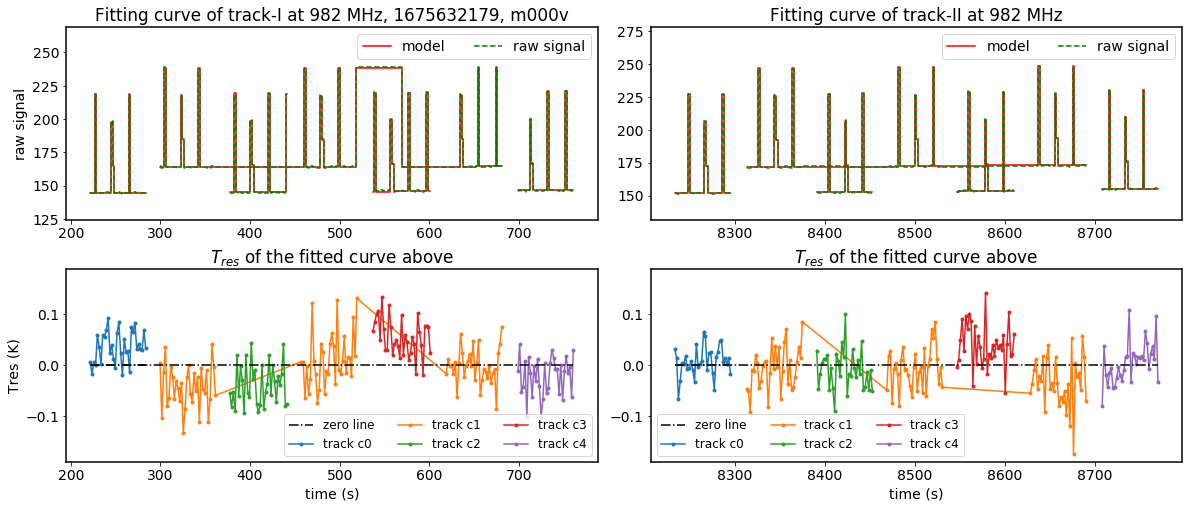

In [89]:
##show model and raw vis
plt.figure(figsize=(20,8))
plt.subplots_adjust(wspace=0.1,hspace=0.25)
plt.subplot(221)
m=ks.calc_total_model_v3(timestamps, nd_ratio, T_ptr, eta_pa, Tnda, Tel, Tgal, gta, sma, nd_0, nd_1x)
ma=np.ma.array(m,mask=visa_ptr[:,ch_plot].mask)
plt.plot(timestamps[dp_c0a]-timestamps[0],ma[dp_c0a],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_c0a]-timestamps[0],visa_ptr[dp_c0a,ch_plot],'g--',drawstyle='steps-mid')
plt.plot(timestamps[dp_c1a]-timestamps[0],ma[dp_c1a],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_c1a]-timestamps[0],visa_ptr[dp_c1a,ch_plot],'g--',drawstyle='steps-mid')
plt.plot(timestamps[dp_c2a]-timestamps[0],ma[dp_c2a],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_c3a]-timestamps[0],ma[dp_c3a],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_c4a]-timestamps[0],ma[dp_c4a],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_c2a]-timestamps[0],visa_ptr[dp_c2a,ch_plot],'g--',drawstyle='steps-mid')
plt.plot(timestamps[dp_c3a]-timestamps[0],visa_ptr[dp_c3a,ch_plot],'g--',drawstyle='steps-mid')
plt.plot(timestamps[dp_c4a]-timestamps[0],visa_ptr[dp_c4a,ch_plot],'g--',drawstyle='steps-mid')
#plt.xlabel('time (s)')
plt.ylabel('raw signal')
plt.legend(['model','raw signal'],ncol=2)
plt.ylim(np.nanmin(visa_ptr[dp_c0a,ch_plot])-20,np.nanmax(visa_ptr[dp_c1a,ch_plot])+30)
plt.title('Fitting curve of track-I at '+ str(int(freqs[ch_plot]/1e6)) +' MHz, '+str(fname)+', '+str(recv))
plt.subplot(223)
ga=ks.func_gt(timestamps,gta)
resia=(visa_ptr[:,ch_plot]-ma)/ga
plt.plot([timestamps[dp_c0a][0]-timestamps[0],timestamps[dp_c0a][-1]-timestamps[0]],[0,0],'k-.')
plt.plot(timestamps[dp_c0a]-timestamps[0],resia[dp_c0a],'.-')
plt.plot(timestamps[dp_c1a]-timestamps[0],resia[dp_c1a],'.-')
plt.plot(timestamps[dp_c2a]-timestamps[0],resia[dp_c2a],'.-')
plt.plot(timestamps[dp_c3a]-timestamps[0],resia[dp_c3a],'.-')
plt.plot(timestamps[dp_c4a]-timestamps[0],resia[dp_c4a],'.-')
plt.plot([timestamps[dp_c0a][0]-timestamps[0],timestamps[dp_c4a][-1]-timestamps[0]],[0,0],'k-.')
plt.xlabel('time (s)')
plt.ylabel('Tres (K)')
plt.legend(['zero line','track c0', 'track c1', 'track c2', 'track c3','track c4'], fontsize=12, ncol=3)
plt.ylim(-0.19,0.19)
plt.title('$T_{res}$ of the fitted curve above')
##show model and raw vis
plt.subplot(222)
m=ks.calc_total_model_v3(timestamps, nd_ratio, T_ptr, eta_pb, Tndb, Tel, Tgal, gtb, smb, nd_0, nd_1x)
mb=np.ma.array(m,mask=visb_ptr[:,ch_plot].mask)
plt.plot(timestamps[dp_c0b]-timestamps[0],mb[dp_c0b],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_c0b]-timestamps[0],visb_ptr[dp_c0b,ch_plot],'g--',drawstyle='steps-mid')
plt.plot(timestamps[dp_c1b]-timestamps[0],mb[dp_c1b],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_c1b]-timestamps[0],visb_ptr[dp_c1b,ch_plot],'g--',drawstyle='steps-mid')
plt.plot(timestamps[dp_c2b]-timestamps[0],mb[dp_c2b],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_c3b]-timestamps[0],mb[dp_c3b],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_c4b]-timestamps[0],mb[dp_c4b],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_c2b]-timestamps[0],visb_ptr[dp_c2b,ch_plot],'g--',drawstyle='steps-mid')
plt.plot(timestamps[dp_c3b]-timestamps[0],visb_ptr[dp_c3b,ch_plot],'g--',drawstyle='steps-mid')
plt.plot(timestamps[dp_c4b]-timestamps[0],visb_ptr[dp_c4b,ch_plot],'g--',drawstyle='steps-mid')
plt.ylim(np.nanmin(visb_ptr[dp_c0b,ch_plot])-20,np.nanmax(visb_ptr[dp_c1b,ch_plot])+30)
#plt.xlabel('time (s)')
#plt.ylabel('raw signal')
plt.legend(['model','raw signal'],ncol=2)
plt.title('Fitting curve of track-II at '+ str(int(freqs[ch_plot]/1e6)) +' MHz')
plt.subplot(224)
gb=ks.func_gt(timestamps,gtb)
resib=(visb_ptr[:,ch_plot]-mb)/gb
plt.plot([timestamps[dp_c0b][0]-timestamps[0],timestamps[dp_c0b][-1]-timestamps[0]],[0,0],'k-.')
plt.plot(timestamps[dp_c0b]-timestamps[0],resib[dp_c0b],'.-')
plt.plot(timestamps[dp_c1b]-timestamps[0],resib[dp_c1b],'.-')
plt.plot(timestamps[dp_c2b]-timestamps[0],resib[dp_c2b],'.-')
plt.plot(timestamps[dp_c3b]-timestamps[0],resib[dp_c3b],'.-')
plt.plot(timestamps[dp_c4b]-timestamps[0],resib[dp_c4b],'.-')
plt.plot([timestamps[dp_c0b][0]-timestamps[0],timestamps[dp_c4b][-1]-timestamps[0]],[0,0],'k-.')
plt.xlabel('time (s)')
#plt.ylabel('residual (K)')
plt.legend(['zero line','track c0', 'track c1', 'track c2', 'track c3','track c4'],fontsize=12, ncol=3)
#plt.title('calibrator Part II of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
plt.ylim(-0.19,0.19)
plt.title('$T_{res}$ of the fitted curve above')
#plt.savefig('F_caliB_ch'+str(ch_plot)+'.pdf', bbox_inches='tight')
plt.show()


In [90]:
print (Tnd_ref)
print (Tnda,Tndb,(Tnda+Tndb)/2.)
Tnd_diff_ratio=abs(Tnda-Tndb)/np.max([Tnda,Tndb])
print (str(round(Tnd_diff_ratio*100,2)),'%')


26.497931406503138
30.380942091563522 30.548405701536712 30.464673896550117
0.55 %


In [91]:
NRMSE1=ks.cal_NRMSE(ma/ga,resia)
NRMSE2=ks.cal_NRMSE(mb/gb,resib)

print (NRMSE1,NRMSE2)


0.002757915276454997 0.0022216917141816357


In [92]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')

end @ Tue Feb 18 13:08:39 2025#


# reload full band result to check

In [93]:
output_file='./'

####save data####
d_r=pickle.load(open(output_file+str(fname)+'_'+str(recv)+'_level2_data','rb'))
T_map1=d_r['T_map']
Tresi_map1=d_r['Tresi_map']
gain_map1=d_r['gain_map']

Tnd_ref_list1=d_r['Tnd_ref_list']
Tnda_list1=d_r['Tnda_list']
Tndb_list1=d_r['Tndb_list']
Tnd_diff_ratio_list1=d_r['Tnd_diff_ratio_list']
NRMSE1_list1=d_r['NRMSE1_list']
NRMSE2_list1=d_r['NRMSE2_list']

d_r2=pickle.load(open(output_file+str(fname)+'_'+str(recv)+'_level2_Tnd_data','rb'))
Tnd_ref_list2=d_r2['Tnd_ref_list']
Tnda_list2=d_r2['Tnda_list']
Tndb_list2=d_r2['Tndb_list']



FileNotFoundError: [Errno 2] No such file or directory: './1675632179_m000v_level2_data'

In [ ]:
assert(Tnda_list1==Tnda_list2)
assert(Tndb_list1==Tndb_list2)

In [ ]:
plot_list=[T_map1,Tresi_map1,gain_map1]
plot_title=['T_map','Tresi_map','gain_map']
i=0
plt.figure(figsize=(8*len(plot_list),6))
for plot_d in plot_list:
    plt.subplot(1,len(plot_list),i+1)
    plt.imshow(plot_d,aspect='auto')
    plt.title(plot_title[i])
    plt.colorbar()
    i+=1
plt.show()

In [ ]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(16,5))
plt.subplots_adjust(hspace=0)
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[2, 1])
plt.subplot(gs[0,0])
plt.plot(Tnda_list1,'.',ms=4)
plt.plot(Tndb_list1,'.',ms=4)
plt.plot(Tnd_ref_list1, color='grey',zorder=0)
plt.legend(['Tnda','Tndb','Tnd_ref'],ncol=3)
#plt.xlabel('channel')
plt.xticks([])
plt.ylabel('Tnd (K)')
plt.title('Tnd result '+fname+', '+recv)
plt.subplot(gs[1,0])
plt.plot(Tnd_diff_ratio_list1,'m.',ms=4)
plt.xlabel('channel')
plt.ylabel('Tnd_diff_ratio')
#plt.savefig(output_file+'Tnd_all_'+str(fname)+'_'+str(recv)+'.pdf', bbox_inches='tight')


In [ ]:
print (ch_plot,Tnda,Tndb)


In [ ]:
Tnda-Tnda_list1[ch_plot]

In [ ]:
Tndb-Tndb_list1[ch_plot]

In [ ]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')